In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

## Oracle

In [2]:
class Oracle(cirq.Gate):
    def __init__(self, case, n):
        super(Oracle, self).__init__()
        self.case = case
        self.n = n
        self.b_str = None
        if self.case == 'balanced':
            b = np.random.randint(1, 2**self.n)
            self.b_str = f'{b:0{self.n}b}'

    def _num_qubits_(self):
        return self.n + 1

    def _decompose_(self, qubits):
        if self.case == 'balanced':
            b_str = self.b_str
            for i in range(len(b_str)):
                if b_str[i] == '1':
                    yield cirq.X(qubits[i])
            
            for i in range(len(b_str)):
                yield cirq.CNOT(qubits[i], qubits[self.n])  # self.n is the index of the auxiliary qubit
            
            for i in range(len(b_str)):
                if b_str[i] == '1':
                    yield cirq.X(qubits[i])
        
        elif self.case == 'constant':
            if np.random.randint(2) == 1:
                yield cirq.X(qubits[self.n])  # Apply X to the auxiliary qubit only

    def _circuit_diagram_info_(self, args):
        return ["Uf"] * (self.n + 1)

In [3]:
n = 2
oracle = Oracle('balanced', n)
qubits = cirq.LineQubit.range(n + 1)
circuit = cirq.Circuit(
    oracle(*qubits),
    cirq.measure(*qubits, key='result')
)

print(circuit)

0: ───Uf───M('result')───
      │    │
1: ───Uf───M─────────────
      │    │
2: ───Uf───M─────────────


In [4]:
sim = cirq.Simulator()

states = ['0b000', '0b010', '0b100', '0b110']
samples = []

for state in states:
    result = sim.simulate(circuit, initial_state=int(state, 2))
    print(f"Input: {state[2:]}, Output: {result.measurements['result']}")

Input: 000, Output: [0 0 1]
Input: 010, Output: [0 1 0]
Input: 100, Output: [1 0 0]
Input: 110, Output: [1 1 1]


## Deutsch-Jozsa Algorithm

In [5]:
def deutsch_jozsa(oracle):
    n = oracle.n
    qubits = cirq.LineQubit.range(n + 1)
    circuit = cirq.Circuit(
        cirq.X(qubits[n]),
        cirq.Moment(cirq.H.on_each(*qubits)),
        oracle(*qubits),
        cirq.H.on_each(*qubits[:-1]),
        cirq.measure(*qubits[:-1], key='result')
    )
    return circuit

In [6]:
circuit = deutsch_jozsa(oracle)

In [7]:
print(circuit)

0: ───────H───Uf───H───M('result')───
              │        │
1: ───────H───Uf───H───M─────────────
              │
2: ───X───H───Uf─────────────────────


In [8]:
def join_array_to_string(array):
    return ''.join([str(int(i)) for i in array])

In [9]:
def run_dj(case, n):
    oracle = Oracle(case, n)
    circuit = deutsch_jozsa(oracle)
    sim = cirq.Simulator()
    result = sim.run(circuit, repetitions=1000)
    return result.histogram(key='result', fold_func=join_array_to_string)

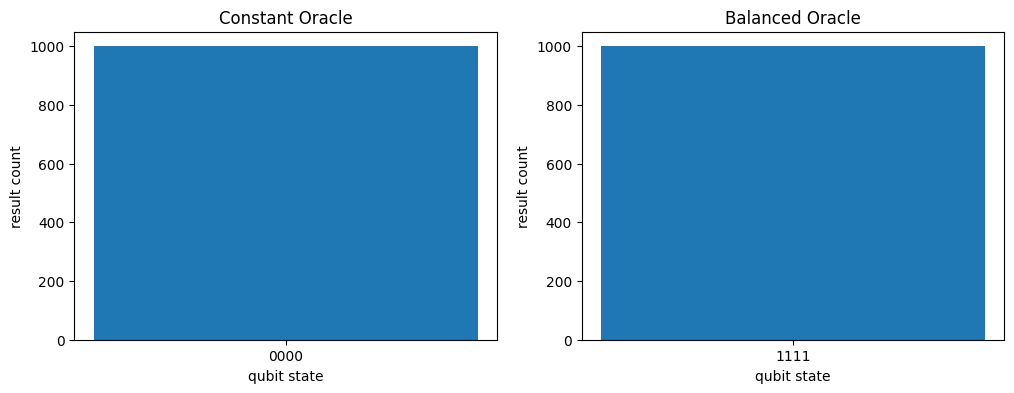

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
cirq.plot_state_histogram(run_dj('constant', 4), ax=ax[0])
ax[0].set_title('Constant Oracle')
cirq.plot_state_histogram(run_dj('balanced', 4), ax=ax[1])
ax[1].set_title('Balanced Oracle')
plt.show()

### In Noisy Environment

In [11]:
def deutsch_jozsa_noisy(oracle):
    n = oracle.n
    qubits = cirq.LineQubit.range(n + 1)
    circuit = cirq.Circuit(
        cirq.X(qubits[n]),
        cirq.Moment(cirq.H.on_each(*qubits)),
        oracle(*qubits),
        cirq.H.on_each(*qubits[:-1]),
        cirq.generalized_amplitude_damp(p=0.1, gamma=0.1).on_each(*qubits),
        cirq.phase_damp(gamma=0.1).on_each(*qubits),
        cirq.measure(*qubits[:-1], key='result')
    )
    return circuit

In [12]:
def run_dj_noisy(case, n):
    oracle = Oracle(case, n)
    circuit = deutsch_jozsa_noisy(oracle)
    sim = cirq.Simulator()
    result = sim.run(circuit, repetitions=1000)
    return result.histogram(key='result', fold_func=join_array_to_string)

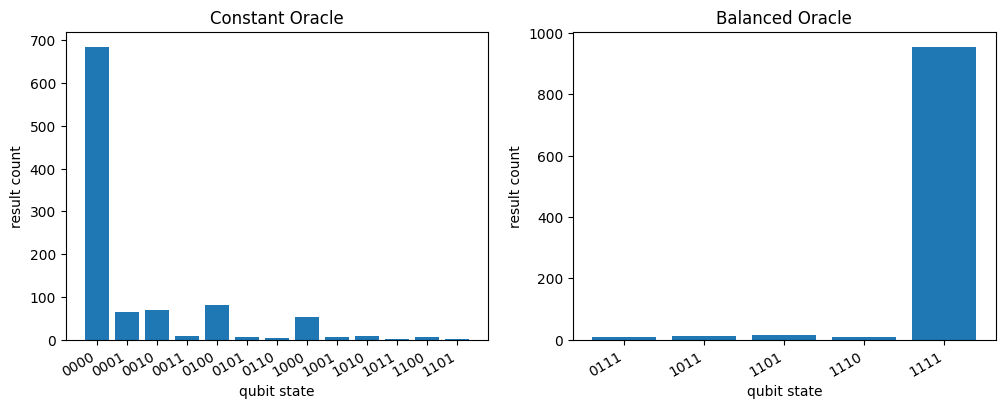

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
cirq.plot_state_histogram(run_dj_noisy('constant', 4), ax=ax[0])
ax[0].set_title('Constant Oracle')
cirq.plot_state_histogram(run_dj_noisy('balanced', 4), ax=ax[1])
ax[1].set_title('Balanced Oracle')
for i in range(2):
    plt.setp(ax[i].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()